In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from xgboost import XGBClassifier


pd.set_option('display.max_columns', None)

random_state = 42

# Funciones

In [2]:
class FrequencySamplerImputerNumeric(BaseEstimator, TransformerMixin):
    """
    Imputa NaNs en columnas numéricas muestreando aleatoriamente valores observados
    según su frecuencia por columna.
    """
    def __init__(self, random_state=42):
        self.random_state = random_state

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        self.value_probs_ = {}

        for col in X_df.columns:
            s = pd.to_numeric(X_df[col], errors="coerce")
            vc = s.dropna().value_counts(normalize=True)

            # Si no hay valores válidos, guardamos None
            if vc.empty:
                self.value_probs_[col] = None
            else:
                self.value_probs_[col] = (vc.index.to_numpy(), vc.to_numpy())

        return self

    def transform(self, X):
        rng = np.random.default_rng(self.random_state)
        X_df = pd.DataFrame(X).copy()

        for col in X_df.columns:
            s = pd.to_numeric(X_df[col], errors="coerce")
            mask = s.isna()

            vp = self.value_probs_.get(col)
            if mask.any():
                if vp is None:
                    # fallback: si todo era NaN en fit, imputar 0.0
                    s.loc[mask] = 0.0
                else:
                    values, probs = vp
                    s.loc[mask] = rng.choice(values, size=int(mask.sum()), p=probs)

            X_df[col] = s

        return X_df.to_numpy(dtype=float)

def calc_log(x, base="10"):
    if base=="10":
        if x > 0:
            return np.log10(x)
        else:
            return 0
    else:
        if x > 0:
            return np.log(x)
        else:
            return 0 

# Columnas descartadas
Dado el EDA, se muestran las razones por las cuales se descartaron las siguientes variables:

### Target leakage
- SHORT_DESC: Leakage -> Relación 1-1 con CLASS

### IDs
- P_ID: Identificador único
- TAX_MAP: Identificador/código casi único

### Redundancia
- SHORT_DESC 1: Redundante con LEVY_CODE_1

### Dirección exacta / alta cardinalidad / PII (riesgo + no generaliza)
- FORMATED_ADDRESS: Dirección completa (alta cardinalidad, PII).
- STREET: Nombre de calle (alta cardinalidad, PII).
- SUFFIX: Parte de dirección; redundante con STREET (Cramér’s V alto) y poca utilidad.
- FREE_LINE_2: Texto libre de mailing (alta cardinalidad, PII).
- FIRST_NAME: PII (nombre).
- LAST_NAME: PII (apellido).
- COMPANY: PII/alta cardinalidad

### Mailing address
- CIVIC 1
- STREET 1
- S_SUFFIX
- CITY 1
- STATE
- ZIP_POSTAL 1

### Unidades
- unit: Alta cardinalidad
- UNIT: Redundante/relacionada con unit

### Geografía en formato string / derivaciones no usadas
- Property_Location: Se usa solo para extraer lat/lon
- geo_cell: Demasiado granular y poco aporte



# Columnas seleccionadas

In [3]:
target = "CLASS"

num_features_final = ["TOTAL_ASSMT", "TOTAL_EXEMPT", "TOTAL_TAXES", "lat", "lon", "CIVIC 1"]
cat_features_final = ["LEVY_CODE_1", "geo_cluster", ]
zip_feature = ["ZIP_POSTAL"]

features_final = num_features_final + cat_features_final + zip_feature

In [4]:
data_path = "../data/"
file_name = "2024_Property_Tax_Roll.csv"
df_ = pd.read_csv(data_path + file_name)

coords = df_["Property_Location"].str.extract(r"POINT\s*\(\s*([-\d\.]+)\s+([-\d\.]+)\s*\)")
df_.loc[:,"lon"] = pd.to_numeric(coords[0], errors="coerce")
df_.loc[:,"lat"] = pd.to_numeric(coords[1], errors="coerce")

valid = df_[["lat", "lon"]].dropna()
kmeans = KMeans(n_clusters=10, random_state=random_state)
df_.loc[valid.index, "geo_cluster"] = kmeans.fit_predict(valid)

df_["geo_cluster"] = df_["geo_cluster"].astype("Int64").astype(str)
df_


,P_ID,TAX_MAP,plat,lot,unit,CLASS,SHORT_DESC,LEVY_CODE_1,SHORT_DESC 1,CIVIC,STREET,SUFFIX,FORMATED_ADDRESS,CITY,ZIP_POSTAL,FIRST_NAME,LAST_NAME,COMPANY,FREE_LINE_2,CIVIC 1,STREET 1,S_SUFFIX,UNIT,CITY 1,STATE,ZIP_POSTAL 1,TOTAL_ASSMT,TOTAL_EXEMPT,TOTAL_TAXES,Property_Location,lon,lat,geo_cluster
0,12.0,000-0001-0022,0.0,1.0,0022,10.0,Utility,C01,C01,NaN,NaN,NaN,NaN,Providence,NaN,NaN,NaN,Algonquin Gas Transmission LLC,PO BOX 2629,NaN,NaN,NaN,NaN,Addison,TX,75001,6160000.0,0.0,216216.00,POINT (-71.412747 41.824461),-71.412747,41.824461,8
1,807.0,005-0514-0000,5.0,514.0,0000,1.0,Single Family,OO01,OO01,135.0,Abbott,St,135 Abbott St,Providence,02906,LYNETTE,LOPES,NaN,135 ABBOTT ST,135,ABBOTT,ST,NaN,PROVIDENCE,RI,02906-1818,436900.0,47708.0,4070.76,POINT (-71.402954036 41.842866001),-71.402954,41.842866,3
2,69878.0,077-0893-0000,77.0,893.0,0000,1.0,Single Family,OO01,OO01,36.0,Wilna,St,36 Wilna St,Providence,02904,K,Karpeh,NaN,36 Wilna St,36,Wilna,St,NaN,Providence,RI,02904,322600.0,0.0,3374.24,POINT (-71.415484981 41.858035988),-71.415485,41.858036,4
3,2050.0,008-0350-0000,8.0,350.0,0000,1.0,Single Family,OO01,OO01,120.0,Morris,Ave,120 Morris Ave,Providence,02906,NaN,NaN,NaN,120 Morris Ave,120,Morris,Ave,NaN,PROVIDENCE,RI,02906-3040,572100.0,57364.0,5383.88,POINT (-71.398264026 41.83631701),-71.398264,41.836317,2
4,5030.0,016-0560-0000,16.0,560.0,0000,1.0,Single Family,OO01,OO01,22.0,John,St,22 John St,Providence,02906,Fergal,Casey,NaN,22 John St,22,John,St,NaN,Providence,RI,02906,643000.0,0.0,6725.48,POINT (-71.400355981 41.821832998),-71.400356,41.821833,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44029,65569.0,080-0866-0306,80.0,866.0,0306,23.0,Residential Condo,NO01,NO01,31.0,Devereux,NaN,31 Devereux Unit 306,Providence,02909,Marlene,Aad,NaN,410 Summer St,410,Summer,St,NaN,New Bedford,MA,02740,154900.0,0.0,2842.44,POINT (-71.471424965 41.834637989),-71.471425,41.834638,5
44030,69909.0,068-0843-0000,68.0,843.0,0000,14.0,CI Vacant Land,C01,C01,306.0,Chalkstone,Ave,306 Chalkstone Ave,Providence,02908,NaN,NaN,Solid Gold Properties Inc,PO Box 28317,NaN,PO Box 28317,NaN,NaN,Providence,RI,02908,112500.0,0.0,3948.76,POINT (-71.418151013 41.83625402),-71.418151,41.836254,8
44031,75378.0,007-0365-0004,7.0,365.0,0004,23.0,Residential Condo,OO01,OO01,44.0,Taft,Ave,44 Taft Ave,Providence,02906,Bilge,Celik,NaN,44 Taft Ave Unit 4,44,Taft,Ave,4,Providence,RI,02906,514200.0,0.0,5378.28,POINT (-71.395496992 41.842759006),-71.395497,41.842759,3
44032,48046.0,128-0137-0000,128.0,137.0,0000,1.0,Single Family,OO01,OO01,22.0,Rialto,St,22 Rialto St,Providence,02909,WAYNE,CIFELLI,NaN,22 RIALTO ST,22,RIALTO,ST,NaN,PROVIDENCE,RI,02908-3813,326900.0,0.0,3419.24,POINT (-71.452007029 41.837112998),-71.452007,41.837113,5


In [5]:
df_model = df_.dropna(subset=[target]).copy()

X = df_model[features_final].copy()
y = df_model[target].astype("Int64").astype(str)

X.shape, y.shape

((44033, 9), (44033,))

In [6]:
df_model[features_final].isna().sum().sort_values(ascending=False)

CIVIC 1         1595
ZIP_POSTAL      1436
TOTAL_ASSMT        0
TOTAL_EXEMPT       0
TOTAL_TAXES        0
lon                0
lat                0
LEVY_CODE_1        0
geo_cluster        0
dtype: int64

In [7]:
(X.isnull().mean().mul(100).sort_values(ascending=False))


CIVIC 1         3.622283
ZIP_POSTAL      3.261190
TOTAL_ASSMT     0.000000
TOTAL_EXEMPT    0.000000
TOTAL_TAXES     0.000000
lon             0.000000
lat             0.000000
LEVY_CODE_1     0.000000
geo_cluster     0.000000
dtype: float64

# Separación train_test

In [8]:
y_int = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, random_state=random_state, stratify=y_int)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((35226, 9), (8807, 9), (35226,), (8807,))

In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

le.classes_

array([ 1,  2,  3,  4,  5,  6,  7, 10, 12, 13, 14, 23, 24, 33, 70, 71, 72,
       73, 74, 75, 76, 78, 79, 80, 82, 83, 84])

In [10]:
# Distribución de clases (proporciones) para confirmar estratificación
dist_train = y_train.value_counts(normalize=True).sort_index()
dist_test  = y_test.value_counts(normalize=True).sort_index()

dist_train.head(), dist_test.head()


(CLASS
 1    0.334412
 2    0.317691
 3    0.011696
 4    0.016408
 5    0.000596
 Name: proportion, dtype: float64,
 CLASS
 1    0.334393
 2    0.317702
 3    0.011695
 4    0.016464
 5    0.000568
 Name: proportion, dtype: float64)

## Preprocesamiento

In [11]:
# Pipelines
numeric_pipe_scaled = Pipeline([
    ("imp_freq", FrequencySamplerImputerNumeric(random_state=random_state)),
    ("scaler", StandardScaler()),
])

numeric_pipe_raw = Pipeline([
    ("imp_freq", FrequencySamplerImputerNumeric(random_state=random_state)),
])

cat_pipe = Pipeline([
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

zip_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocesador final
# Modelos que necesitan estandarización
preprocess_scaled = ColumnTransformer([
    ("num", numeric_pipe_scaled, num_features_final),
    ("cat", cat_pipe,          cat_features_final),
    ("zip", zip_pipe,          zip_feature),
], remainder="drop")

# Modelos que no necesitan estandarización
preprocess_raw = ColumnTransformer([
    ("num", numeric_pipe_raw,  num_features_final),
    ("cat", cat_pipe,          cat_features_final),
    ("zip", zip_pipe,          zip_feature),
], remainder="drop")



# Selección de modelo
- Se usarán 6 modelos para determinar cuál arroja mejores resultados
  - LogisticRegression
  - SGDClassifier
  - RandomForestClassifier 
  - GradientBoostingClassifier
  - AdaBoostClassifier
  - XGBClassifier

In [12]:
# Se guardan ids

id_cols = ["P_ID", "TAX_MAP"]
ids_train = df_model.loc[X_train.index, id_cols].copy()
ids_test  = df_model.loc[X_test.index, id_cols].copy()

In [13]:
# Transformando features a dense 
to_dense = FunctionTransformer(
    lambda x: x.toarray() if hasattr(x, "toarray") else x,
    accept_sparse=True
)

In [14]:
models = {
    "LR": LogisticRegression(
        solver="saga",
        max_iter=5000,
        class_weight="balanced",
        random_state=random_state
    ),

    "SGD": SGDClassifier(
        loss="log_loss",
        alpha=1e-4,
        max_iter=3000,
        tol=1e-3,
        class_weight="balanced",
        random_state=random_state
    ),

    "RF": RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced_subsample",
        random_state=random_state
    ),

    "GradientBoosting": GradientBoostingClassifier(
        n_estimators = 100, 
        learning_rate= 0.03,
        max_depth = 3, 
        random_state=random_state
        ),

    "AdaBoost": AdaBoostClassifier(
        n_estimators=100, 
        learning_rate=0.03, 
        random_state=random_state
        ),

    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=len(le.classes_),
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=random_state,
    )
}


# Piplines

In [15]:
pipelines = {}

pipelines["LR"] = Pipeline([
    ("pre", preprocess_scaled),
    ("model", models["LR"])
])

pipelines["SGD"] = Pipeline([
    ("pre", preprocess_scaled),
    ("model", models["SGD"])
])

pipelines["RF"] = Pipeline([
    ("pre", preprocess_raw),
    ("model", models["RF"])
])

pipelines["GradientBoosting"] = Pipeline([
    ("pre", preprocess_raw),
    ("dense", to_dense),
    ("model", models["GradientBoosting"])
])

pipelines["AdaBoost"] = Pipeline([
    ("pre", preprocess_raw),
    ("dense", to_dense),
    ("model", models["AdaBoost"])
])

pipelines["XGBoost"] = Pipeline([
        ("pre", preprocess_raw),
        ("model", models["XGBoost"])
    ])

## Selección mejor modelo

In [16]:
is_model = True
if not is_model:
        
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=random_state)

    results = []
    for name, pipe in pipelines.items():
        print(name)
        scores = cross_validate(
            pipe,
            X_train,
            y_train_enc,
            cv=cv,
            scoring={"acc": "accuracy", "f1m": "f1_macro"},
            return_train_score=False
        )
        results.append({
            "model": name,
            "acc_mean": float(np.mean(scores["test_acc"])),
            "acc_std": float(np.std(scores["test_acc"])),
            "f1_macro_mean": float(np.mean(scores["test_f1m"])),
            "f1_macro_std": float(np.std(scores["test_f1m"])),
        })

    result_cv = pd.DataFrame(results).sort_values("f1_macro_mean", ascending=False).reset_index(drop=True)
    result_cv.to_csv(data_path+"result_cv.csv",index=False)
else:
    result_cv = pd.read_csv(data_path+"result_cv.csv")

## Entrenamiento mejor modelo.
- Se escoge XGBoost

In [17]:
result_cv

,model,acc_mean,acc_std,f1_macro_mean,f1_macro_std
0,XGBoost,0.815335,0.001845,0.575176,0.004740
1,RF,0.798785,0.003350,0.555899,0.024155
2,GradientBoosting,0.755805,0.004656,0.489645,0.013436
3,LR,0.588486,0.001022,0.333229,0.001894
4,SGD,0.562113,0.004116,0.277753,0.003758
5,AdaBoost,0.430847,0.001845,0.051926,0.001197


In [18]:
if not is_model:
    best_name = result_cv["model"].values[0]
    best_pipe = pipelines[best_name]

    best_pipe.fit(X_train, y_train_enc)
    with open("modelo_xgb.pkl", "wb") as f:
        pickle.dump(best_pipe, f)
else:
        
    with open("modelo_xgb.pkl", "rb") as f:
        best_pipe = pickle.load(f)



## Predicción

In [19]:
y_pred_enc = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)

# volver a clases originales
y_pred = le.inverse_transform(y_pred_enc)
y_true = y_test

## Métricas

In [20]:
acc = accuracy_score(y_true, y_pred)
acc

0.8406949017826729

/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

Text(0.5, 1.0, 'Matriz de confusión')

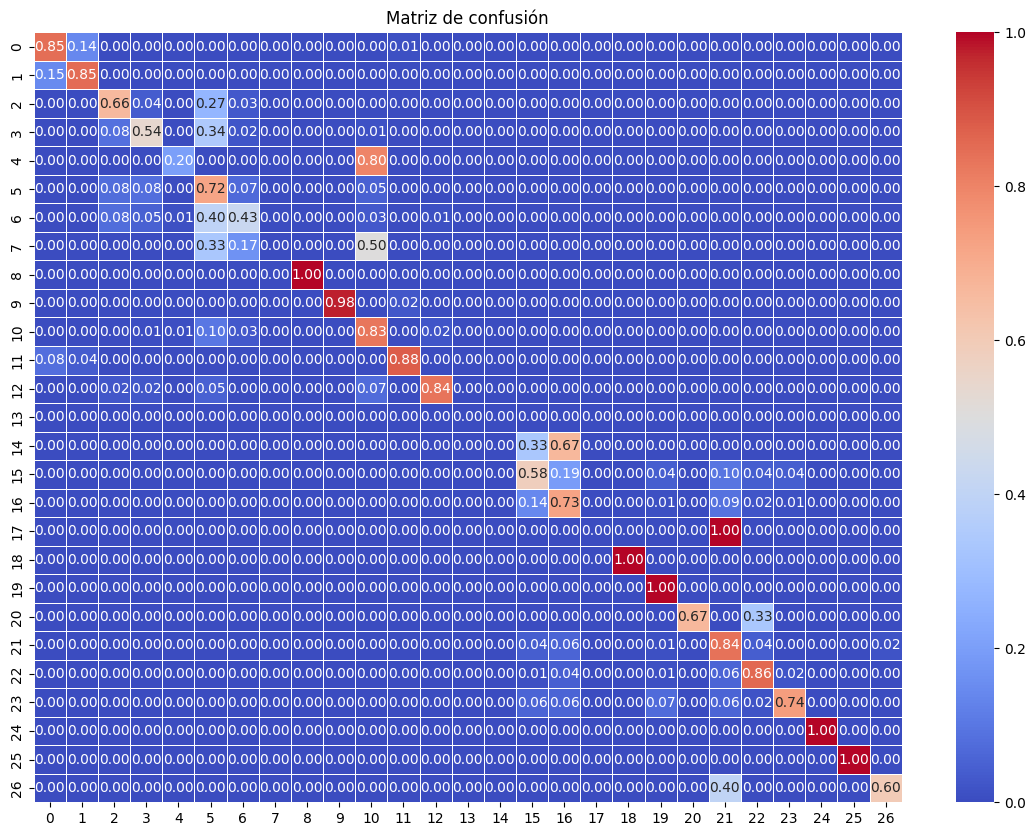

In [21]:
labels = le.classes_ 
cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
cr = classification_report(y_true, y_pred, digits=4)

plt.figure(figsize=(14, 10))
sns.heatmap(cm_norm, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5 )
plt.title('Matriz de confusión')


In [22]:
print(cr)

              precision    recall  f1-score   support

           1     0.8404    0.8475    0.8440      2945
           2     0.8421    0.8503    0.8462      2798
           3     0.6071    0.6602    0.6326       103
           4     0.6842    0.5379    0.6023       145
           5     0.2500    0.2000    0.2222         5
           6     0.5694    0.7193    0.6357       285
           7     0.5500    0.4272    0.4809       103
          10     0.0000    0.0000    0.0000         6
          12     1.0000    1.0000    1.0000       124
          13     0.9933    0.9754    0.9843       610
          14     0.8885    0.8306    0.8586       307
          23     0.9278    0.8810    0.9038       773
          24     0.8875    0.8353    0.8606        85
          70     0.0000    0.0000    0.0000         3
          71     0.6462    0.5833    0.6131        72
          72     0.6875    0.7253    0.7059        91
          73     0.0000    0.0000    0.0000         1
          74     1.0000    

### Probabilidad asignada a cada clase y top 10 menor confianza
- p_true: probabilidad que el modelo le da a la clase real

In [23]:
# Probabilidad
p_true = y_proba[np.arange(len(y_test_enc)), y_test_enc]

# top10
top_10 = np.argsort(p_true)[:10]
id_top10 = X_test.index[top_10]

In [25]:
df_top10 = pd.DataFrame({
    "p_true": p_true[top_10],
    "y_true": y_true.loc[id_top10].values,
    "y_pred": y_pred[top_10],
    "max_proba": y_proba[top_10].max(axis=1),
    "pred_class": le.inverse_transform(y_proba[top_10].argmax(axis=1)),
}, index=id_top10).sort_values("p_true")
df_top10 = df_top10.join(ids_test.loc[df_top10.index])

df_top10

,p_true,y_true,y_pred,max_proba,pred_class,P_ID,TAX_MAP
40547,0.000024,24,14,0.994350,14,70862.0,116-0561-0004
39744,0.000043,24,4,0.775612,4,70863.0,116-0561-0005
7880,0.000053,10,14,0.812138,14,4566.0,015-0467-0000
10493,0.000055,70,72,0.518461,72,9593.0,030-0452-0000
25107,0.000092,5,14,0.983456,14,29349.0,077-0044-0000
42036,0.000094,24,14,0.920153,14,70861.0,116-0561-0003
39397,0.000129,24,6,0.780371,6,70859.0,116-0561-0001
7438,0.000134,10,7,0.515404,7,20428.0,056-0273-LL01
12057,0.000163,76,79,0.986166,79,6378.0,020-0372-REVO
37584,0.000169,79,78,0.504221,78,40601.0,107-0111-0000


In [26]:
ind_test = X_test.index
df_final = df_model.loc[ind_test]
df_final.loc[:,"p_true"] = p_true
df_final.loc[:,"pred_class"] = le.inverse_transform(y_proba.argmax(axis=1))

## Nivel alerta
grupo_alerta, corte = pd.qcut(p_true, q=4, labels=["CRITICA", "ALTA", "MEDIA", "BAJA" ], retbins=True, duplicates="drop")
df_final.loc[:,"nivel_alerta"] = grupo_alerta

df_final.head()


,P_ID,TAX_MAP,plat,lot,unit,CLASS,SHORT_DESC,LEVY_CODE_1,SHORT_DESC 1,CIVIC,STREET,SUFFIX,FORMATED_ADDRESS,CITY,ZIP_POSTAL,FIRST_NAME,LAST_NAME,COMPANY,FREE_LINE_2,CIVIC 1,STREET 1,S_SUFFIX,UNIT,CITY 1,STATE,ZIP_POSTAL 1,TOTAL_ASSMT,TOTAL_EXEMPT,TOTAL_TAXES,Property_Location,lon,lat,geo_cluster,p_true,pred_class,nivel_alerta
3808,628.0,005-0315-0000,5.0,315.0,0000,13.0,Residential Vacant Land,NO01,NO01,1.0,Steele,St,1 Steele St,Providence,02906,Nathan,Applegate,NaN,70 Evergreen St,70,Evergreen,St,NaN,Providence,RI,02906,73700.0,0.0,1352.40,POINT (-71.403665419 41.846115898),-71.403665,41.846116,3,0.976598,13,BAJA
32489,29585.0,077-0417-0000,77.0,417.0,0000,1.0,Single Family,NO01,NO01,29.0,Windmill,St,29 Windmill St,Providence,02904,Liam,Mallon,NaN,29 Windmill St,29,Windmill,St,NaN,Providence,RI,02904,252300.0,0.0,4629.72,POINT (-71.41789503 41.854803004),-71.417895,41.854803,4,0.574853,1,CRITICA
27945,33245.0,086-0452-0000,86.0,452.0,0000,1.0,Single Family,OO01,OO01,124.0,Freeman Pkwy,NaN,124 Freeman Pkwy,Providence,02906,Helen,Burnham,NaN,Helen Metcalf Burnham Revocable Trust,124,Freeman Pkwy,NaN,NaN,Providence,RI,02906,1483700.0,0.0,15518.76,POINT (-71.393158022 41.837744993),-71.393158,41.837745,3,0.986904,1,BAJA
1065,3804.0,013-0212-0000,13.0,212.0,0000,1.0,Single Family,OO01,OO01,67.0,Manning,St,67 Manning St,Providence,02906,David,Ward,NaN,c/o Tiedemann Advisors,601,"Union St, Suite 3315",NaN,NaN,Seattle,WA,98101,1975100.0,0.0,20658.56,POINT (-71.394910007 41.826489019),-71.394910,41.826489,2,0.831954,1,ALTA
7334,21213.0,059-0264-0000,59.0,264.0,0000,1.0,Single Family,OO01,OO01,74.0,Homer,St,74 Homer St,Providence,02905,STEVEN,DACRUZ,NaN,74 HOMER ST,74,HOMER,ST,NaN,PROVIDENCE,RI,02905-1321,269100.0,71992.0,2061.68,POINT (-71.406669985 41.787739984),-71.406670,41.787740,6,0.966079,1,MEDIA


In [27]:
df_final.groupby("nivel_alerta")["p_true"].agg(
    n="count", mean="mean", median="median", min="min", max="max"
)

/tmp/ipykernel_847/1201353345.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby("nivel_alerta")["p_true"].agg(


,n,mean,median,min,max
nivel_alerta,,,,,
CRITICA,2202,0.355029,0.370415,0.000024,0.654593
ALTA,2202,0.802533,0.813552,0.654686,0.899276
MEDIA,2201,0.943865,0.946885,0.899286,0.975325
BAJA,2202,0.992230,0.995016,0.975326,0.999984


# Guarda resultados

In [40]:
df_final.to_csv(data_path + "df_pred_test.csv")

In [29]:
pd.crosstab(df_final["geo_cluster"], df_final["nivel_alerta"])

nivel_alerta,CRITICA,ALTA,MEDIA,BAJA
geo_cluster,,,,
0,183,143,229,253
1,175,225,239,207
2,263,256,157,154
3,253,245,236,147
4,307,335,252,195
5,258,247,277,291
6,122,129,127,188
7,199,209,229,226
8,210,163,184,321


### Distribución probabilidad

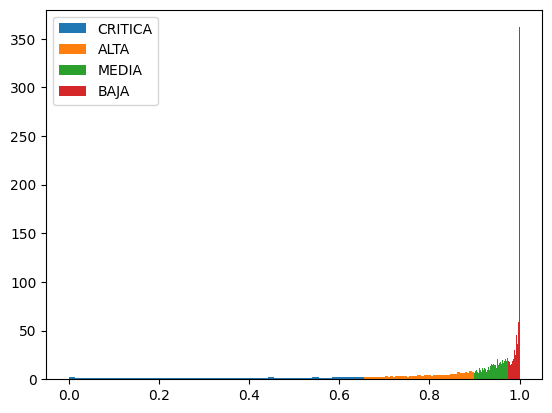

In [30]:
prob_crit = df_final[df_final["nivel_alerta"] == "CRITICA"]["p_true"]
prob_alta = df_final[df_final["nivel_alerta"] == "ALTA"]["p_true"]
prob_media = df_final[df_final["nivel_alerta"] == "MEDIA"]["p_true"]
prob_baja = df_final[df_final["nivel_alerta"] == "BAJA"]["p_true"]
plt.hist(prob_crit, bins=int(np.sqrt(len(prob_crit))), density=True, label="CRITICA")
plt.hist(prob_alta, bins=int(np.sqrt(len(prob_alta))), density=True, label="ALTA")
plt.hist(prob_media, bins=int(np.sqrt(len(prob_media))), density=True, label="MEDIA")
plt.hist(prob_baja, bins=int(np.sqrt(len(prob_baja))), density=True, label="BAJA")
plt.legend(loc=0)